
# From Experiments to Decisions: Data Science in Chemical R&D

**Goal today:**  
Show how your experimental data (formulations process parameters + test results)  
→ can be used as inputs and outputs of machine learning models  
→ can be used to predict a kez performance metric (e.g. cleaning score) from recipe  
→ can be used to show what dives performance
→ and be used to optimize and shorten the search for recipes that maximize cleaning subject to contstraints

We'll briefly touch:
- Feature engineering
- Dimensionality reduction (Principal Component Analysis)
- Supervised learning (predicting performance of individual formulations)
- Unsupervised learning (finding formulation families)
- How all of this is based on math, not magic

> This notebook uses a **synthetic dataset** that loosely mimics chemical R&D formulations.  
> No real company data is used.



### 1) Let's generate the dataset: inputs and targets

One row = one experiment

- **Inputs (features)** = what we choose or know *before* the experiment:
  - `solvent_ratio_A`, `surfactant_pct`, `inhibitor_pct`, `propellant_pressure_bar`,  
    `spray_rate_g_s`, `viscosity_cSt`, `flash_off_s`, `temp_C`, `soak_time_s`,  
    `substrate_type`, `contamination_type`, `cost_eur_per_l`, `VOC_g_l`.
- **Targets (labels)** = what we measure *after* the experiment:
  - `cleaning_score` (0–100), `corrosion_risk` (0/1).

We want to learn relationships of the form:

$$
\text{cleaning\_score} \approx f(\text{inputs}) + \text{noise}.
$$

In [ ]:

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# optional: silence a noisy sklearn warning from KMeans
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

plt.rcParams["figure.figsize"] = (6, 4)

# ---- Synthetic dataset generation ----
rng = np.random.default_rng(42)
n = 900

substrates = np.array(["steel", "aluminum", "plastic"])
contams = np.array(["oil", "grease", "brake_dust", "adhesive"])

df = pd.DataFrame({
    "solvent_ratio_A": rng.uniform(0.10, 0.85, n),
    "surfactant_pct": rng.uniform(0.2, 6.0, n),
    "inhibitor_pct": rng.uniform(0.0, 2.0, n),
    "propellant_pressure_bar": rng.uniform(2.0, 9.0, n),
    "spray_rate_g_s": rng.uniform(0.6, 4.0, n),
    "viscosity_cSt": rng.uniform(0.8, 18.0, n),
    "flash_off_s": rng.uniform(5, 90, n),
    "temp_C": rng.uniform(5, 45, n),
    "soak_time_s": rng.uniform(10, 180, n),
    "substrate_type": rng.choice(substrates, n, p=[0.5, 0.3, 0.2]),
    "contamination_type": rng.choice(contams, n, p=[0.35, 0.30, 0.25, 0.10]),
})

# Cost + VOC (simple but plausible relationships)
df["cost_eur_per_l"] = (
    2.5
    + 6.0*df["surfactant_pct"]/6.0
    + 2.0*df["inhibitor_pct"]/2.0
    + 1.5*(df["propellant_pressure_bar"]-2.0)/7.0
    + rng.normal(0, 0.25, n)
).clip(2.0, None)

df["VOC_g_l"] = (
    150
    + 650*df["solvent_ratio_A"]
    + 15*(df["flash_off_s"]/90)
    + rng.normal(0, 20, n)
).clip(50, 900)

# Effects by contamination/substrate (encoded via bonuses/penalties)
contam_bonus = df["contamination_type"].map({
    "oil": 8, "grease": 2, "brake_dust": 0, "adhesive": -6
}).astype(float)

substrate_penalty = df["substrate_type"].map({
    "steel": 0, "aluminum": -2, "plastic": -5
}).astype(float)

# Cleaning score (nonlinear + interactions)
base = (
    35
    + 40*df["solvent_ratio_A"]
    + 18*np.log1p(df["surfactant_pct"])
    + 0.10*df["soak_time_s"]
    - 0.90*df["viscosity_cSt"]
    + 0.35*df["temp_C"]
    + contam_bonus
    + substrate_penalty
)
# Too-fast flash-off can hurt (less dwell time)
base -= 10*(df["flash_off_s"] < 15).astype(float)

df["cleaning_score"] = (base + rng.normal(0, 6, n)).clip(0, 100)

# Corrosion risk: higher solvent + higher VOC + low inhibitor => riskier (esp. on steel/aluminum)
risk_logit = (
    -3.0
    + 3.2*df["solvent_ratio_A"]
    + 0.0025*df["VOC_g_l"]
    - 1.8*df["inhibitor_pct"]
    + (df["substrate_type"].isin(["steel","aluminum"])).astype(int)*0.6
)
p = 1/(1+np.exp(-risk_logit))
df["corrosion_risk"] = (rng.uniform(0,1,n) < p).astype(int)

# Save for reference (optional)
df.to_csv("tunap_like_formulation.csv", index=False)

df.head()


#### Describe and visualize the generated dataset

In [ ]:
df.describe()

In [ ]:

sns.scatterplot(data=df, x="solvent_ratio_A", y="cleaning_score", hue="contamination_type")
plt.title("Cleaning performance vs solvent ratio");
plt.show()


### 2) We will engineer a feature 'harshness index' using domain knowledge

##### Definition: Feature engineering
**Feature engineering** is a part of machine learning where you design or transform the input variables (features) to make patterns in the dataset easier for a machine learning model to learn.

Examples:

- Combining several raw measurement features into one feature (composite feature or index), e.g. our `harshness_index`).

- Transforming features: taking logs, ratios, or differences of the original features (e.g. log(price), VOC_g_l/ solvent_ration_A).

- Encoding categorical features into numeric form, so that machine learning models can use them. This means converting words into numeric codes.

In [ ]:

# A simple engineered feature: "harshness_index"
df["harshness_index"] = (
    df["solvent_ratio_A"] * 2.0
    + df["VOC_g_l"] / 400.0
    + (df["temp_C"] - 20) / 20.0
)

df[["solvent_ratio_A", "VOC_g_l", "temp_C", "harshness_index"]].head()


**Interpretation of resulting harshness_index feature**: Here we combined 3 seperate features, solvent fraction, VOC content and temperature into one rough indicator of "how aggressive" the formulation + conditions are.


Good feature engineering injects **domain, (here chemistry) knowledge** into the data and often improves model performance more than just switching algorithm.


### 3) Predicting 'cleaning score' from input features

##### Supervised learning – high-level math

We assume there is some (unknown) function $f$ such that

$$
\text{cleaning\_score}_i = f(x_i) + \varepsilon_i,
$$

where $x_i$ is the vector of inputs for experiment $i$, and $\varepsilon_i$ is noise.

A model $\hat{f}_\theta$ (e.g. Random Forest) is chosen to minimize prediction error on known data.

For a simple regression model, we would minimize the *mean squared error* (MSE):

$$
\text{MSE}(\theta) = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{f}_\theta(x_i) \right)^2.
$$

Random Forest uses many decision trees instead of fitted lines and averages them,  
but the principle is still: **fit parameters to minimize a well-defined loss function**.


In [ ]:

feature_cols = [
    "solvent_ratio_A",
    "surfactant_pct",
    "inhibitor_pct",
    "propellant_pressure_bar",
    "spray_rate_g_s",
    "viscosity_cSt",
    "flash_off_s",
    "temp_C",
    "soak_time_s",
    "cost_eur_per_l",
    "VOC_g_l",
    "harshness_index",
]

X = df[feature_cols]
y = df["cleaning_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

rf = RandomForestRegressor(
    n_estimators= # write your number of trees here
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# type the r2 code here
# type the rsme code here
# type the variable names here


##### Definition: R² score
The **R² score** (coefficient of determination) tells us *how much of the variation* in `cleaning_score` our model can explain. 

- R² = 1 → perfect predictions  
- R² = 0 → model is no better than predicting the mean  

A higher R² means the model captures more of the systematic pattern in the data.

##### Definition: Mean Squared Error (MSE)
**MSE** measures the *average squared difference* between the true values and the predictions:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2.
$$

Squaring penalizes large errors more strongly.  
Lower MSE means better predictive accuracy.

In [ ]:

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual cleaning_score")
plt.ylabel("Predicted cleaning_score")
plt.title(f"RF regression, R² = {r2:.2f}, RMSE = {rmse:.1f}")
plt.plot([0, 100], [0, 100], "r--")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()


### 4) Feature importance: determining the importance in each feature in the prediction

##### Definition: Feature importance

**Feature importances** (derived from the Random Forest, or from other modelling techniques) tells us how much each input variable contributes to reducing prediction error across all trees.

- Higher importance → this feature is more influential for predicting `cleaning_score`.

This helps us see which knobs (e.g. solvent, surfactant, VOC) matter most for predictive performance.


In [ ]:

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
# type the variable 'importances' here to show the feature importances


### 5) Principal Component Analysis: reducing the dimensionality of the dataset to 2 dimensions (features) using linear transformations

##### Definition: Principal Component (PC)

A **principal component (PC)** is a new axis in feature space that is a *weighted combination* (linear transform) of the original variables.

- PC1 captures the direction of **maximum variance** in the data.  
- PC2 captures the next most variable direction, orthogonal to PC1.

Plotting data in PC1–PC2 space lets us visualize high-dimensional structure in the data in 2D.



##### PCA – high-level math

We want directions $w_1, w_2, \dots$ in feature space that capture as much variance as possible.

For the first principal component, PCA solves:

$$
\max_{w_1} \ \mathrm{Var}(X w_1) \quad \text{subject to } \lVert w_1 \rVert = 1.
$$

This leads to an eigenvalue problem of the covariance matrix $\Sigma$:

$$
\Sigma w_1 = \lambda_1 w_1,
$$

where $w_1$ is the eigenvector with the largest eigenvalue $\lambda_1$.

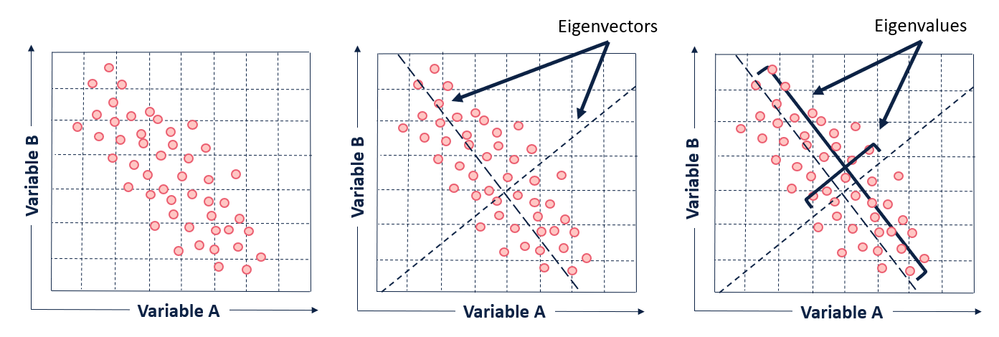

In summary, PCA is **an optimization problem with a clear objective (maximize variance)**  
and a constraint (unit length). The technique is based on linear algebra, and is deterministic, "white box".


In [ ]:
num_cols = [
    "solvent_ratio_A",
    "surfactant_pct",
    "inhibitor_pct",
    "propellant_pressure_bar",
    "spray_rate_g_s",
    "viscosity_cSt",
    "flash_off_s",
    "temp_C",
    "soak_time_s",
    "cost_eur_per_l",
    "VOC_g_l",
    "harshness_index",
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])

# type how many PC-s you want to keep
# run fit + transform

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["cleaning_score"] = df["cleaning_score"]
pca_df["contamination_type"] = df["contamination_type"]
pca_df.head()


##### Definition: Scaler

A **scaler** (here `StandardScaler`) transforms each numeric feature to have **mean 0 and standard deviation 1**. Many methods (PCA, clustering, some models) work better when features are on comparable scales, so we scale first and then apply PCA or K-Means.


In [ ]:

plt.figure(figsize=(6,5))
scatter = plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["cleaning_score"],
    cmap="viridis", alpha=0.6
)
plt.colorbar(scatter, label="cleaning_score")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of formulations (colored by cleaning_score)")
plt.show()


### 6) Perform K-Means Clustering on the 2-dimensional dataset

##### Definition: Cluster

A **cluster** is a group of experiments that are **similar to each other** according to the K-Means algorithm.

- Each cluster has a center (mean point) in PC1–PC2 space.  
- Experiments in the same cluster tend to represent a similar “family” of formulations or operating conditions.



##### K-Means – high-level math

Given points $x_1, \dots, x_n$, K-Means tries to find cluster centers $\mu_1, \dots, \mu_k$
and assignments $c_i$ that minimize:

$$
\sum_{i=1}^n \left\lVert x_i - \mu_{c_i} \right\rVert^2.
$$

Objective: minimize the sum of squared distances to the nearest center.  
Variables: cluster centers $\mu_j$ and assignments $c_i$.

The algorithm alternates between:
1. **Assignment step:** assign each point to the nearest center.
2. **Update step:** recompute each center as the mean of its assigned points.

Again, this is a clear optimization problem.


In [ ]:

# choose how many clusters you would like to have
# initiate k-means clustering algorithm
cluster_labels = kmeans.fit_predict(X_pca)

pca_df["cluster"] = cluster_labels


In [ ]:

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("K-Means clusters of formulations in PCA space")
plt.show()


In [ ]:

cluster_summary = df.assign(cluster=cluster_labels).groupby("cluster")[
    num_cols + ["cleaning_score", "VOC_g_l", "cost_eur_per_l"]
].mean().round(2)

cluster_summary


In [ ]:

sil = silhouette_score(X_pca, cluster_labels)
sil


##### Silhouette score

The **silhouette score** measures how well separated the clusters are, on average.

- Values near **1** → points are well matched to their own cluster and far from others.  
- Values near **0** → clusters overlap.  
- Values < 0 → some points may be closer to another cluster than to their assigned one.

It is a quick, single-number indicator of clustering quality.


In [ ]:
# Elbow plot for K-Means: how inertia changes with number of clusters
ks = range(2, 11)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Within-cluster sum of squares (inertia)")
plt.title("Elbow plot for K-Means on PCA space")
plt.show()


##### Definition: Elbow plot

An **elbow plot** shows how the K-Means **within-cluster sum of squares** (also called *inertia*) changes as we increase the number of clusters \(k\).

- For small \(k\), adding more clusters usually **reduces inertia a lot**.
- After some point, extra clusters only **reduce inertia a little** → diminishing returns.

On the curve, we look for the **“elbow”** – the point where the line bends.  
That \(k\) is often a good trade-off between **model simplicity** (few clusters) and **cluster quality** (low inertia).


In [ ]:
candidates = df.copy()
# Predict the cleaning performance of cnadidates based on subset of features

candidates = candidates[
    (candidates["pred_cleaning"] > 80) &   # still high cleaning
    (candidates["VOC_g_l"] < 400) &       # a bit more VOC allowed
    (candidates["cost_eur_per_l"] < 5.0)  # slightly higher cost allowed
]

candidates[["solvent_ratio_A", "surfactant_pct", "inhibitor_pct",
            "VOC_g_l", "cost_eur_per_l", "pred_cleaning"]].head(10)


##### Definition: Candidate (model-guided experiment)

A **candidate** here is a **promising experiment / formulation** suggested by the model under given constraints.

We use the trained model to predict `pred_cleaning` for many possible recipes and then filter for those that satisfy our targets (e.g. high cleaning, low VOC, low cost). These filtered rows are the “candidates” for next experiments.



## Summary

In this notebook we:

- Used a tabular dataset of experiments to build a **supervised model** (Random Forest) to predict cleaning performance.
- **Engineered** a simple feature ("harshness_index") using domain intuition.
- Compressed many variables into 2 principal components (**PCA**) – using linear algebra and eigenvalues.
- Grouped formulations into k clusters (**K-Means**) – minimizing a distance-based clustering objective.
- Sketched how such models can suggest promising **next experiments** under linear constraints.

Across all methods, the pattern is the same, they are optimization problems:

- **Supervised learning:** minimize prediction error (e.g., MSE).
- **PCA:** maximize explained variance of projections.
- **K-Means:** minimize within-cluster squared distance.

Data science and machine learning are:

- Not black magic,
- Not replacing chemistry or experimentation,
- But are a set of quantitative tools that can be applied on top of existing physical experiments,
  helping you **move faster**, **see patterns**, and **design better experiments**.
